# WGU C964 Task 2

*Name*: Daniel McNevin

*Email*: dmcnev2@wgu.edu

### Terms

```
 The information used here was obtained free of
 charge from and is copyrighted by Retrosheet.  Interested
 parties may contact Retrosheet at "www.retrosheet.org".
```

# Global Setup

### Global Imports

Install packages and import needed libraries

In [1]:
%pip install notebook ipywidgets matplotlib pandas numpy scikit-learn plotly seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import display, clear_output
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### General Setup

Set up global variables

In [3]:
HOME_DIR = "."

RETROSHEET_DIR = f"{HOME_DIR}/retrosheet"
CACHE_DIR = f"{HOME_DIR}/cached"
DAILY_FILES = f"{HOME_DIR}/retrosplits/daybyday"

START_YEAR = 1980
END_YEAR = 2025

#### Batting Stats

In [4]:
BATTING_STATS = [
    'ba',
    'slg',
    'obp',
    'ops',
    'run_diff',
]

BATTING_PERIODS = [
    5,
    20,
    100,
    162,
]

#### Pitching Stats

In [5]:
PITCHING_STATS = [
    'P_ERA',
    'P_WHIP'
]

MERGED_PITCHING_STATS = [
    'era',
    'whip'
]

PITCHING_PERIODS = [
    5,
    20,
]

PITCHING_STAT_MAPPER = {
    'P_ERA_5': "starting_pitcher_era_5",
    'P_ERA_20': "starting_pitcher_era_20",
    'P_WHIP_5': "starting_pitcher_whip_5",
    'P_WHIP_20': "starting_pitcher_whip_20",
}

# Data Setup

## Data Import

### Team Import

Get a list of all teams that are all active in 2024

This will set a `TEAMS` global variable that has a DataFrame of all teams

In [6]:
TEAMS_DF = pd.read_csv(f"{RETROSHEET_DIR}/reference/teams.csv.zip")

TEAMS = TEAMS_DF[TEAMS_DF['LAST'] == 2024].dropna()
TEAMS.set_index('TEAM', inplace=True)

### Team Helper Methods

Methods to get the team and team name from the `TEAMS` DataFrame

#### Team Lookup Methods

In [7]:
def get_team(team_code):
    return TEAMS.loc[TEAMS.index == team_code]

In [8]:
def get_team_name(team_code):
    return get_team(team_code).apply(lambda tt: f"{tt['CITY']} {tt['NICKNAME']}", axis=1).iloc[0]

### Player Lookup Methods

In [9]:
PLAYERS_DF = pd.read_csv(f"{RETROSHEET_DIR}/reference/biofile.csv.zip")
PLAYERS_DF.set_index('PLAYERID', inplace=True)

def get_player_name(player_id):
    row = PLAYERS_DF.loc[player_id][["NICKNAME", "LAST"]]
    return f"{row['NICKNAME']} {row['LAST']}"

### Game Log Information

Read data from each season. Range end is exclusive, so it will read up to, but not including `END_YEAR`

In [10]:
def read_all_seasons(start_year, end_year):
    all_seasons = []

    print("Reading Seasons ", end="")

    for season_year in range(start_year, end_year):
        print(f"{season_year} ", end="")
        _season = pd.read_csv(f"{RETROSHEET_DIR}/seasons/{season_year}/GL{season_year}.TXT.zip", header=None)
        _season['season'] = season_year
        all_seasons.append(_season)

    return pd.concat(all_seasons, axis=0, ignore_index=True)

ALL_SEASONS_DF = read_all_seasons(START_YEAR, END_YEAR)

Reading Seasons 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 

### Header Columns



In [11]:
GAMELOG_COLUMNS = [
    'date', 'game_num', 'day_of_week', 'visiting_team',
    'visiting_team_league', 'visiting_team_game_num', 'home_team',
    'home_team_league', 'home_team_game_num', 'visiting_score',
    'home_score', 'num_outs', 'day_night', 'completion_info',
    'forfeit_info', 'protest_info', 'park_id', 'attendance',
    'time_of_game_minutes', 'visiting_line_score',
    'home_line_score', 'visiting_abs', 'visiting_hits',
    'visiting_doubles', 'visiting_triples', 'visiting_homeruns',
    'visiting_rbi', 'visiting_sac_hits', 'visiting_sac_flies',
    'visiting_hbp', 'visiting_bb', 'visiting_iw', 'visiting_k',
    'visiting_sb', 'visiting_cs', 'visiting_gdp', 'visiting_ci',
    'visiting_lob', 'visiting_pitchers_used',
    'visiting_individual_er', 'visiting_er', 'visiting_wp',
    'visiting_balks', 'visiting_po', 'visiting_assists',
    'visiting_errors', 'visiting_pb', 'visiting_dp',
    'visiting_tp', 'home_abs', 'home_hits', 'home_doubles',
    'home_triples', 'home_homeruns', 'home_rbi',
    'home_sac_hits', 'home_sac_flies', 'home_hbp', 'home_bb',
    'home_iw', 'home_k', 'home_sb', 'home_cs', 'home_gdp',
    'home_ci', 'home_lob', 'home_pitchers_used',
    'home_individual_er', 'home_er', 'home_wp', 'home_balks',
    'home_po', 'home_assists', 'home_errors', 'home_pb',
    'home_dp', 'home_tp', 'ump_home_id', 'ump_home_name',
    'ump_first_id', 'ump_first_name', 'ump_second_id',
    'ump_second_name', 'ump_third_id', 'ump_third_name',
    'ump_lf_id', 'ump_lf_name', 'ump_rf_id', 'ump_rf_name',
    'visiting_manager_id', 'visiting_manager_name',
    'home_manager_id', 'home_manager_name',
    'winning_pitcher_id', 'winning_pitcher_name',
    'losing_pitcher_id', 'losing_pitcher_name',
    'save_pitcher_id', 'save_pitcher_name',
    'game_winning_rbi_id', 'game_winning_rbi_name',
    'visiting_starting_pitcher_id', 'visiting_starting_pitcher_name',
    'home_starting_pitcher_id', 'home_starting_pitcher_name',
    'visiting_1_id', 'visiting_1_name', 'visiting_1_pos',
    'visiting_2_id', 'visiting_2_name', 'visiting_2_pos',
    'visiting_3_id', 'visiting_3_name', 'visiting_3_pos',
    'visiting_4_id', 'visiting_4_name', 'visiting_4_pos',
    'visiting_5_id', 'visiting_5_name', 'visiting_5_pos',
    'visiting_6_id', 'visiting_6_name', 'visiting_6_pos',
    'visiting_7_id', 'visiting_7_name', 'visiting_7_pos',
    'visiting_8_id', 'visiting_8_name', 'visiting_8_pos',
    'visiting_9_id', 'visiting_9_name', 'visiting_9_pos',
    'home_1_id', 'home_1_name', 'home_1_pos',
    'home_2_id', 'home_2_name', 'home_2_pos',
    'home_3_id', 'home_3_name', 'home_3_pos',
    'home_4_id', 'home_4_name', 'home_4_pos',
    'home_5_id', 'home_5_name', 'home_5_pos',
    'home_6_id', 'home_6_name', 'home_6_pos',
    'home_7_id', 'home_7_name', 'home_7_pos',
    'home_8_id', 'home_8_name', 'home_8_pos',
    'home_9_id', 'home_9_name', 'home_9_pos',
    'misc', 'acquisition_info'
]

### Add Columns and Fields to DataFrame

* Add the column headers to the DataFrame
* Add `datetime` as a parsed version of the games' `date` for easier compairision and graphing
* Add a `game_id` for a consistent way to reference a game, includes:
    * `date` - The game date
    * `game_num` - Used for doubleheader games
    * `home_team` - The home team
    * `visiting_team` - The visiting team

In [12]:
## Add Columns to dataframe
ALL_SEASONS_DF.columns = [*GAMELOG_COLUMNS, *['season']]
ALL_SEASONS_DF['datetime'] = pd.to_datetime(ALL_SEASONS_DF['date'], format='%Y%m%d')
ALL_SEASONS_DF['game_id'] = (ALL_SEASONS_DF["date"].astype(str)
                             + "_"
                             + ALL_SEASONS_DF["game_num"].astype(str)
                             + "_" + ALL_SEASONS_DF["home_team"]
                             + "_" + ALL_SEASONS_DF["visiting_team"])

### Drop columns that we don't need

Out model doesn't currently include any information about position players, so remove it from the DataFrame


In [13]:
ALL_SEASONS_DF.drop([
    'visiting_1_id', 'visiting_1_name', 'visiting_1_pos',
    'visiting_2_id', 'visiting_2_name', 'visiting_2_pos',
    'visiting_3_id', 'visiting_3_name', 'visiting_3_pos',
    'visiting_4_id', 'visiting_4_name', 'visiting_4_pos',
    'visiting_5_id', 'visiting_5_name', 'visiting_5_pos',
    'visiting_6_id', 'visiting_6_name', 'visiting_6_pos',
    'visiting_7_id', 'visiting_7_name', 'visiting_7_pos',
    'visiting_8_id', 'visiting_8_name', 'visiting_8_pos',
    'visiting_9_id', 'visiting_9_name', 'visiting_9_pos',
    'home_1_id', 'home_1_name', 'home_1_pos',
    'home_2_id', 'home_2_name', 'home_2_pos',
    'home_3_id', 'home_3_name', 'home_3_pos',
    'home_4_id', 'home_4_name', 'home_4_pos',
    'home_5_id', 'home_5_name', 'home_5_pos',
    'home_6_id', 'home_6_name', 'home_6_pos',
    'home_7_id', 'home_7_name', 'home_7_pos',
    'home_8_id', 'home_8_name', 'home_8_pos',
    'home_9_id', 'home_9_name', 'home_9_pos',
    'misc', 'acquisition_info'
], axis=1, inplace=True)

## Data Exploration and Cleaning


### Check for ties

There are exceptional situations where a game can end in a tie. These games can be safely removed if they don't make up a large percentage of the total games 

In [14]:
ties = ALL_SEASONS_DF[ALL_SEASONS_DF['home_score'] == ALL_SEASONS_DF['visiting_score']]
(ties.shape[0] / ALL_SEASONS_DF.shape[0]) * 100

0.03460720818707668

### Remove ties

In [15]:
ALL_SEASONS_DF = ALL_SEASONS_DF[ALL_SEASONS_DF['home_score'] != ALL_SEASONS_DF["visiting_score"]]

### Set the binary value of a win or loss based on the score

In [16]:
ALL_SEASONS_DF['home_win'] = np.where(ALL_SEASONS_DF['home_score'] > ALL_SEASONS_DF['visiting_score'], 1, 0)
ALL_SEASONS_DF['visiting_win'] = np.where(ALL_SEASONS_DF['home_score'] > ALL_SEASONS_DF['visiting_score'], 0, 1)

### Batting Statistics

* Batting Average (BA)

$$
\text{Batting Average} = \frac{\text{Hits}}{\text{At Bats}}
$$

* Slugging Percentage (SLG)

$$
\text{SLG} = \frac{1B + (2 \times 2B) + (3 \times 3B) + (4 \times HR)}{\text{At Bats}}
$$

* On-Base Percentage (OBP)

$$
\text{OBP} = \frac{H + BB + HBP}{AB + BB + HBP + SF}
$$

* On-Base Plus Slugging Percentages (OPS)

$$
\text{OPS} = \text{OBP} + \text{SLG}
$$

In [17]:
def calculate_batting_stats(dataframe):
    dataframe = dataframe.copy()

    for location in ['home', 'visiting']:
        ## Batting average
        dataframe[f"{location}_ba"] = dataframe[f"{location}_hits"] / dataframe[f"{location}_abs"]

        ## Get the singles
        dataframe[f"{location}_singles"] = dataframe[f"{location}_hits"] - dataframe[f"{location}_doubles"] - dataframe[f"{location}_triples"] - dataframe[f"{location}_homeruns"]

        ## Calculate the slugging percentage
        ##  Total Bases = (1B) + (2×2B) + (3×3B) + (4×HR)
        ##  Slugging = Total Bases / At Bats
        dataframe[f"{location}_slg"] = (dataframe[f"{location}_singles"] + (dataframe[f"{location}_doubles"] * 2) + (dataframe[f"{location}_triples"] * 3) + (dataframe[f"{location}_homeruns"] * 4)) / dataframe[f"{location}_abs"]

        ## Calculate On-base Percentage (OBP)
        ##  (Hits + Walks + Hit-by-Pitch) / (At Bats + Walks + Hit-by-Pitch + Sacrifice Flies)
        dataframe[f"{location}_obp"] = (dataframe[f"{location}_hits"] + dataframe[f"{location}_bb"] + dataframe[f"{location}_hbp"]) / (
                dataframe[f"{location}_hits"] + dataframe[f"{location}_bb"] + dataframe[f"{location}_hbp"] + dataframe[f"{location}_abs"] + dataframe[f"{location}_sac_flies"])

        ## Calculate OPS
        ##  OBP + SLG
        dataframe[f"{location}_ops"] = dataframe[f"{location}_obp"] + dataframe[f"{location}_slg"]

        return dataframe

ALL_SEASONS_DF = calculate_batting_stats(ALL_SEASONS_DF)

## Per-Team Statistics

Create a dataframe per-team that includes all the games for that team. This will make functions later like rolling averages much easier.

We normalize the selected team for each stat with the `team_` prefix (ie. `team_ba`) regardless of whether it is a home or away game. The opponent similarly is normalized with the `opponent_` prefix

* `is_home_game` is added to the DataFrame

In [18]:
def team_games(team_games_dataframe, team_code):
    team_games_dataframe = team_games_dataframe.copy()

    # Home games (team is home)
    home = team_games_dataframe[team_games_dataframe['home_team'] == team_code].copy()
    home['is_home_game'] = True

    # Rename columns
    home = home.rename(columns=lambda col: f"team_{col.removeprefix('home_')}" if col.startswith('home_') else col)
    home = home.rename(
        columns=lambda col: f"opponent_{col.removeprefix('visiting_')}" if col.startswith('visiting_') else col)

    # Away games (team is visitor)
    away = team_games_dataframe[team_games_dataframe['visiting_team'] == team_code].copy()
    away['is_home_game'] = False

    # Rename columns
    away = away.rename(
        columns=lambda col: f"team_{col.removeprefix('visiting_')}" if col.startswith('visiting_') else col)
    away = away.rename(columns=lambda col: f"opponent_{col.removeprefix('home_')}" if col.startswith('home_') else col)

    # Combine both
    combined = pd.concat([home, away], ignore_index=True).sort_values(by=['date', 'game_num']).copy()
    combined['team_run_diff'] = combined['team_score'] - combined['opponent_score']

    return combined

### Extract the team data for each team

In [19]:
def extract_team_dictionary(dataframe):
    all_teams = {}

    print("Loading Teams ", end="")

    for team in TEAMS.index:
        print(f"{team} ", end="")
        all_teams[team] = team_games(dataframe, team)

    return all_teams

TEAM_DATA = extract_team_dictionary(ALL_SEASONS_DF)

Loading Teams ANA ARI ATL BAL BOS CHA CHN CIN CLE COL DET HOU KCA LAN MIA MIL MIN NYA NYN OAK PHI PIT SDN SEA SFN SLN TBA TEX TOR WAS 

### Calculate the Rolling Average

Add rolling averages for each selected batting stat over a period of 5, 20, 100, and 162 games

The rolling averages are all calculate for all values prior to th current column, since using the current game would be determinisitic

In [20]:
def calculate_team_batting_rolling_averages(team, team_df):

    team_df = team_df.copy()

    print(f"{team} ", end="")
    new_cols = {}

    for stat in BATTING_STATS:
        for period in BATTING_PERIODS:
            col_name = f"team_{stat}_{period}"

            ## Shift 1 so we don't include the current game
            new_cols[col_name] = team_df[f"team_{stat}"].shift(1).rolling(window=period, min_periods=1).mean()

    # Add all new columns at once
    new_cols_df = pd.DataFrame(new_cols, index=team_df.index)
    return pd.concat([team_df, new_cols_df], axis=1).drop_duplicates()

print("Processing Team: ", end="")
for team in TEAMS.index:
    TEAM_DATA[team] = calculate_team_batting_rolling_averages(team, TEAM_DATA[team])

Processing Team: ANA ARI ATL BAL BOS CHA CHN CIN CLE COL DET HOU KCA LAN MIA MIL MIN NYA NYN OAK PHI PIT SDN SEA SFN SLN TBA TEX TOR WAS 

### Per-Team Data Exploration

Explore some of the stats that have been calculated

In [22]:
def create_per_team_batting_stats_graph():
    dropdown_stats = [f"team_{stat}" for stat in BATTING_STATS] + [f"team_{stat}_{period}" for stat in BATTING_STATS for period in BATTING_PERIODS]
    
    team_batting_stats_dropdown = widgets.Dropdown(options=TEAM_DATA.keys(), description='Team:')
    stats_batting_stats_dropdown = widgets.Dropdown(options=dropdown_stats, description='Stat:')
    
    batting_stats_output = widgets.Output()
    
    def update_batting_stats_plot(change):
        with batting_stats_output:
            batting_stats_output.clear_output()
            team = team_batting_stats_dropdown.value
            stat = stats_batting_stats_dropdown.value
    
            df = TEAM_DATA[team].groupby('season')[stat].mean().reset_index()
            fig = px.line(df, x='season', y=stat, title=f"Mean {stat} Per Season for {team}")
            fig.show()
    
    # Attach handlers
    team_batting_stats_dropdown.observe(update_batting_stats_plot, names='value')
    stats_batting_stats_dropdown.observe(update_batting_stats_plot, names='value')
    
    # Display widgets and initial plot
    display(team_batting_stats_dropdown, stats_batting_stats_dropdown, batting_stats_output)
    
    # Trigger initial plot
    update_batting_stats_plot(None)

create_per_team_batting_stats_graph()

Dropdown(description='Team:', options=('ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CHA', 'CHN', 'CIN', 'CLE', 'COL', '…

Dropdown(description='Stat:', options=('team_ba', 'team_slg', 'team_obp', 'team_ops', 'team_run_diff', 'team_b…

Output()

### Plot the Rolling Average of OPS For All Teams

In [23]:
def create_all_teams_batting_stats_graph():
    all_teams_stat_dropdown = widgets.Dropdown(options=dropdown_stats, description='Stat:')
    
    all_teams_stats = widgets.Output()
    
    def update_figure(change):
        with all_teams_stats:
            all_teams_stats.clear_output()
            selected_stat = all_teams_stat_dropdown.value
    
            all_teams_fig = go.Figure()
            for t in TEAMS.index:
                graph_df = TEAM_DATA[t]
                if selected_stat not in graph_df.columns:
                    continue  # Skip if stat missing
    
                all_teams_fig.add_trace(go.Scatter(
                    x=graph_df['datetime'],
                    y=graph_df[selected_stat],
                    mode='lines',
                    name=_team,
                    connectgaps=False
                ))
    
            all_teams_fig.update_layout(title=f"Team Average of {selected_stat}")
            all_teams_fig.show()
    
    all_teams_stat_dropdown.observe(update_figure, names='value')
    
    display(all_teams_stat_dropdown, all_teams_stats)
    
    update_figure(None)

create_all_teams_batting_stats_graph()

Dropdown(description='Stat:', options=('team_ba', 'team_slg', 'team_obp', 'team_ops', 'team_run_diff', 'team_b…

Output()

## Add the Aggregated Data Back Into the Game Logs

Merge the batting rolling averages in to a new DataFrame that has the original game data plus the rolling averages for the home and away team going into that game

In [22]:
MERGED_DF = ALL_SEASONS_DF.copy()
MERGED_DF.set_index('game_id', inplace=True)

fields_to_merge = [
    'game_id',
    'team_team',
    'is_home_game',
    *[f"team_{stat}_{period}" for stat in BATTING_STATS for period in BATTING_PERIODS]
]

for i in ['home', 'visiting']:

    ## Make sure the new fields are present to update
    for field in [f"{i}_{stat}_{period}" for stat in BATTING_STATS for period in BATTING_PERIODS]:
        MERGED_DF[field] = None

    rename_map = {
        f"team_{stat}_{period}": f"{i}_{stat}_{period}"
        for stat in BATTING_STATS
        for period in BATTING_PERIODS
    }

    for _team in TEAMS.index:
        team_df = TEAM_DATA[_team][fields_to_merge].copy()

        is_home_game = (i == 'home')
        team_df = team_df.query('is_home_game == @is_home_game').copy()
        team_df.rename(columns=rename_map, inplace=True)
        team_df.set_index('game_id', inplace=True)
        MERGED_DF.update(team_df)

MERGED_DF.reset_index(inplace=True)

## Pitching Statistics

Pitching statistics are stored in a separte daily event file

We will create a DataFrame for all pitchers' events

In [23]:
PITCHING_DF = pd.DataFrame()

_dfs = []

## Read data from 1980-2024
for year in range(START_YEAR, END_YEAR):
    print(f"{year} ", end="")
    _season = pd.read_csv(f"{DAILY_FILES}/playing-{year}.csv.zip")
    _season['season'] = year
    _season['game.datetime'] = pd.to_datetime(_season['game.date'], format='%Y-%m-%d')

    ## Filter for only pitchers and remove batting and fielding data
    year_pitching_data = _season[
                             ## Events
                             (_season['game.source'] == 'evt')
                             ## Regular Season
                             & (_season['season.phase'] == 'R')
                             ## Total batters faced is more than 0
                             & (_season['P_TBF'] > 0)
                             ].loc[:,~(_season.columns.str.startswith('B_') | _season.columns.str.startswith('F_'))].copy()
    
    _dfs.append(year_pitching_data)

print()
PITCHING_DF = pd.concat(_dfs, axis=0, ignore_index=True)

1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 


### Calculate Per-Game Pitching Stata

* Earned Run Average

$$
\text{ERA} = \left( \frac{\text{Earned Runs}}{\text{Innings Pitched}} \right) \times 9
$$

* Walks and Hits per Innings Pitched

$$
\text{WHIP} = \frac{\text{Walks} + \text{Hits}}{\text{Innings Pitched}}
$$

In [24]:
## Calculate ERA, WHIP
PITCHING_DF['P_IP'] = PITCHING_DF['P_OUT'] / 3.0
PITCHING_DF['P_ERA'] = (PITCHING_DF['P_ER'] * 9) / PITCHING_DF['P_IP']
PITCHING_DF['P_WHIP'] = (PITCHING_DF['P_BB'] + PITCHING_DF['P_H']) / PITCHING_DF['P_IP']

### Calculate Pitching Rolling Averages

Add rolling averages for pitching stats for the previous 5 and 20 games. Since these are individual stats, they can be shorter timeframes to represent short and longer term performance

In [25]:
PITCHING_DF = PITCHING_DF.sort_values(by=['person.key', 'game.datetime'])

for period in PITCHING_PERIODS:
    for _stat in PITCHING_STATS:
        PITCHING_DF[f"{_stat}_{period}"] = (
            PITCHING_DF
            .groupby('person.key')[_stat]
            .transform(lambda s: s.shift(1).rolling(window=period, min_periods=1).mean())
        )


### Data Exploration

#### 20 Game Rolling Average WHIP for Selected Pitchers

In [26]:
pitching_players = [
    "skubt001",
    "salec001",
    "skenp001",
    "imans001",
]

pitching_df = PITCHING_DF.query('`person.key`==@pitching_players and season==2024')

pitching_stats = [f"{stat}_{period}" for stat in PITCHING_STATS for period in PITCHING_PERIODS]

pitching_stat_dropdown = widgets.Dropdown(
    options=pitching_stats,
    description='Pitching Stat:',
    value=pitching_stats[0]
)

pitching_output = widgets.Output()

def update_pitching_graph(change=None):
    pitching_stat = pitching_stat_dropdown.value

    pitching_fig = go.Figure()
    for pid, group in pitching_df.groupby('person.key'):
        group_sorted = group.sort_values('game.datetime')

        pitching_fig.add_trace(go.Scatter(
            x=group_sorted['game.datetime'],
            y=group_sorted[pitching_stat],
            mode='lines',
            name=get_player_name(pid)
        ))

    pitching_fig.update_layout(
        title=f"{pitching_stat} Rolling Average (2024)",
        xaxis_title='Date',
        yaxis_title=pitching_stat,
        legend_title='Pitcher'
    )

    with pitching_output:
        clear_output(wait=True)
        pitching_fig.show()


# Update graph when the dropdown's value changes
pitching_stat_dropdown.observe(update_pitching_graph, names='value')

# Display widgets
display(pitching_stat_dropdown, pitching_output)

# Initial draw
update_pitching_graph()

Dropdown(description='Pitching Stat:', options=('P_ERA_5', 'P_ERA_20', 'P_WHIP_5', 'P_WHIP_20'), value='P_ERA_…

Output()

#### 20 Game Rolling WHIP Average For All Pitchers on a Single Team

In [27]:
team_pitching_stats_team_options = list(TEAM_DATA.keys())
team_pitching_stats_stat_options = [f"{stat}_{period}" for stat in PITCHING_STATS for period in PITCHING_PERIODS]

team_pitching_stats_team_dropdown = widgets.Dropdown(
    options=team_pitching_stats_team_options,
    description='Team:',
    value=team_pitching_stats_team_options[0]
)

team_pitching_stats_stat_dropdown = widgets.Dropdown(
    options=team_pitching_stats_stat_options,
    description='Stat:',
    value=team_pitching_stats_stat_options[0]
)

team_pitching_stats_output = widgets.Output()

def team_pitching_stats_update_graph(change=None):
    team_pitching_stats_df = PITCHING_DF[
        (PITCHING_DF['season'] == 2024) &
        (PITCHING_DF['team.key'] == team_pitching_stats_team_dropdown.value)
    ].copy()

    team_pitching_stats_df['player_name'] = team_pitching_stats_df['person.key'].map(get_player_name)

    team_pitching_stats_fig = px.line(
        team_pitching_stats_df,
        x='game.datetime',
        y=team_pitching_stats_stat_dropdown.value,
        color='player_name',
        title=f"{team_pitching_stats_stat_dropdown.value} for {team_pitching_stats_team_dropdown.value} (2024)"
    )

    team_pitching_stats_fig.update_yaxes(type='log')  # optional

    with team_pitching_stats_output:
        clear_output(wait=True)
        team_pitching_stats_fig.show()

team_pitching_stats_team_dropdown.observe(team_pitching_stats_update_graph, names='value')
team_pitching_stats_stat_dropdown.observe(team_pitching_stats_update_graph, names='value')

display(team_pitching_stats_team_dropdown, team_pitching_stats_stat_dropdown, team_pitching_stats_output)

team_pitching_stats_update_graph()

Dropdown(description='Team:', options=('ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CHA', 'CHN', 'CIN', 'CLE', 'COL', '…

Dropdown(description='Stat:', options=('P_ERA_5', 'P_ERA_20', 'P_WHIP_5', 'P_WHIP_20'), value='P_ERA_5')

Output()

### Add Starting Pitching Data to Games

We need to find the data for a pitcher as of the game date to add in the pitcher's data that is representative of their stats up until, but not including that game.

#### Data Preparation

Keep the original index to join back to at the end

In [28]:
MERGED_DF = MERGED_DF.reset_index().rename(columns={'index': 'original_game_index'})

In [29]:
# Prepare the pitcher stats lookup table (the "right" side of the merge)
# We select and rename columns for the merge and sort by time, which is required.
stats_to_get = list(PITCHING_STAT_MAPPER.keys())
pitcher_lookup = PITCHING_DF[['person.key', 'game.datetime'] + stats_to_get].rename(columns={
    'person.key': 'pitcher_id',
    'game.datetime': 'datetime'
}).sort_values('datetime')

#### Unpivot the Games DataFrame

In [30]:
# Reshape g_df from "wide" to "long" format so we can process all pitchers in one go.
home_pitchers = MERGED_DF[[
    'original_game_index',
    'datetime',
    'home_starting_pitcher_id'
]].rename(
    columns={'home_starting_pitcher_id': 'pitcher_id'}
)
home_pitchers['role'] = 'home'

visiting_pitchers = MERGED_DF[[
    'original_game_index',
    'datetime',
    'visiting_starting_pitcher_id'
]].rename(
    columns={'visiting_starting_pitcher_id': 'pitcher_id'}
)
visiting_pitchers['role'] = 'visiting'

# Combine and sort by time, as required by merge_asof
merged_df_long = pd.concat([home_pitchers, visiting_pitchers]).sort_values('datetime')


#### Perform the Time-Series Merge

In [31]:
merged_long = pd.merge_asof(
    merged_df_long,
    pitcher_lookup,
    on='datetime',
    by='pitcher_id',
    direction='backward'  # This finds the last value <= the key
)

#### Pivot Results Back to Wide Format

In [32]:
# Pivot the merged stats back to the original format with home/visiting columns
pivoted_stats = merged_long.pivot_table(
    index='original_game_index',
    columns='role',
    values=stats_to_get
)

# Flatten the multi-level column index created by the pivot
pivoted_stats.columns = [f"{role}_{PITCHING_STAT_MAPPER[stat]}" for stat, role in pivoted_stats.columns]

#### Final Join

Join the new stats columns back to the original games DataFrame

In [33]:
MERGED_DF = MERGED_DF.set_index('original_game_index').join(pivoted_stats)

# Modeling


## Model Training

In [34]:
_training_df = MERGED_DF.copy()

TRAINING_FIELDS = [
    'home_win',
    *[f"{ha}_{stat}_{period}" for ha in ['home', 'visiting'] for stat in BATTING_STATS for period in BATTING_PERIODS],
    *[f"{ha}_starting_pitcher_{stat}_{period}" for ha in ['home', 'visiting'] for stat in MERGED_PITCHING_STATS for
      period in PITCHING_PERIODS]
]

TRAINER_DF = _training_df[TRAINING_FIELDS].dropna()

x = TRAINER_DF.drop('home_win', axis=1)
y = TRAINER_DF['home_win']

#### Split up the dataset with training and test set

* `x_train`	Features for training
* `x_test` Features for testing
* `y_train`	Targets for training
* `y_test` Targets for testing

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#### Create a Pipeline

Using a standard scaler to ensure that all the features are on the same scale and then using the Logistic Regression model

* `penalty='l2'`: Adds regularization to prevent overfitting.
* `max_iter=5000`: Gives the solver more time to converge

In [36]:
PIPELINE = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='saga',
        penalty='l2',
        max_iter=5000,
    )
)

LOGMODEL = PIPELINE.named_steps['logisticregression']

#### Fit the training data into the model

In [37]:
PIPELINE.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=5000, solver='saga'))])

#### Get the prediction results for the test set

In [38]:
predictions = PIPELINE.predict(x_test)

## Model Metrics

#### Classification Report

Compare the `y_test` set vs. the actual predictions to get a better sense of the model's accuracy

In [39]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.54      0.33      0.41     12520
           1       0.57      0.76      0.65     14551

    accuracy                           0.56     27071
   macro avg       0.56      0.55      0.53     27071
weighted avg       0.56      0.56      0.54     27071



#### Confusion Matrix

This shows similar data to the classifiaction report in a graphical format

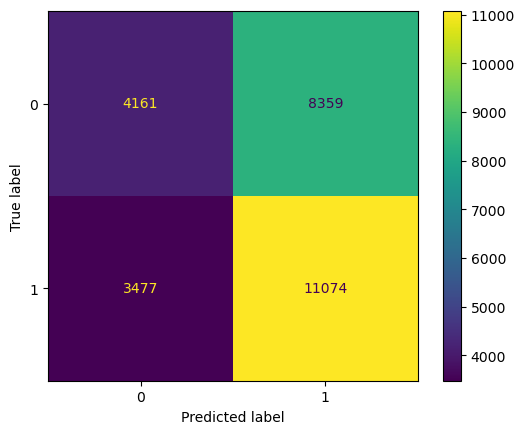

In [40]:
ConfusionMatrixDisplay.from_estimator(PIPELINE, x_test, y_test)

#### ROC Curve

We are looking for a higher Area Under the Curve (AUC) score that shows that the model is good at distinguishing wins and losses

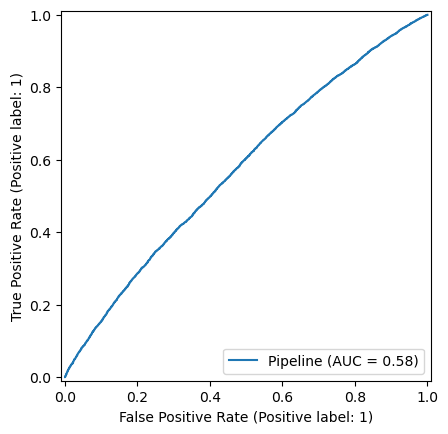

In [41]:
RocCurveDisplay.from_estimator(PIPELINE, x_test, y_test)

#### Precision Recall Graph

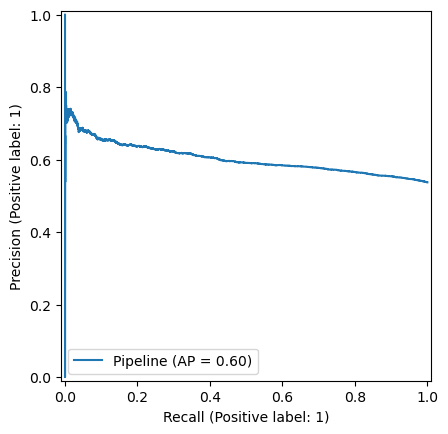

In [42]:
PrecisionRecallDisplay.from_estimator(PIPELINE, x_test, y_test)

#### Calibration Display

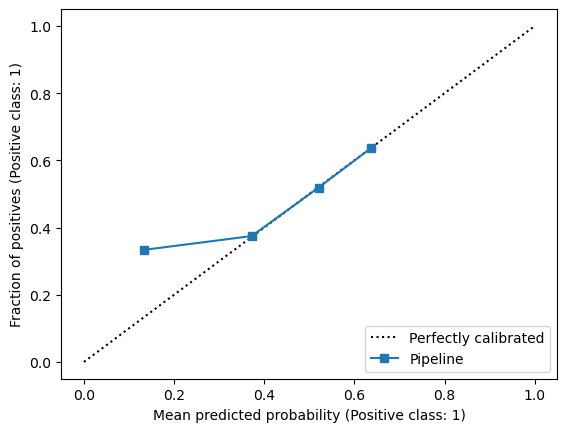

In [43]:
CalibrationDisplay.from_estimator(PIPELINE, x_test, y_test)

#### Histogram of Predicted Probabilities

Text(0.5, 1.0, 'Histogram of Predicted Probabilities')

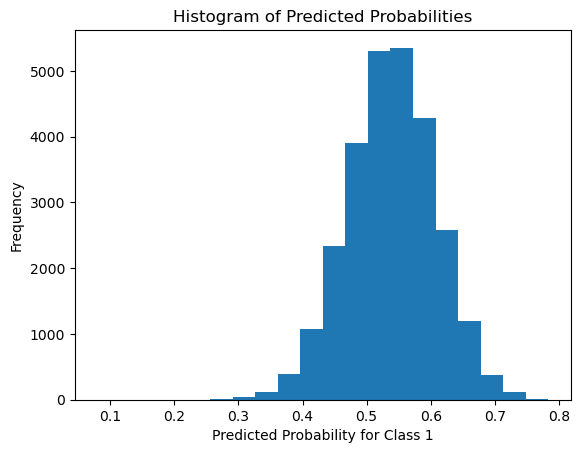

In [44]:
y_proba = PIPELINE.predict_proba(x_test)[:, 1]
plt.hist(y_proba, bins=20)
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')

#### Which Features Had the Biggest Impact to the Predictions

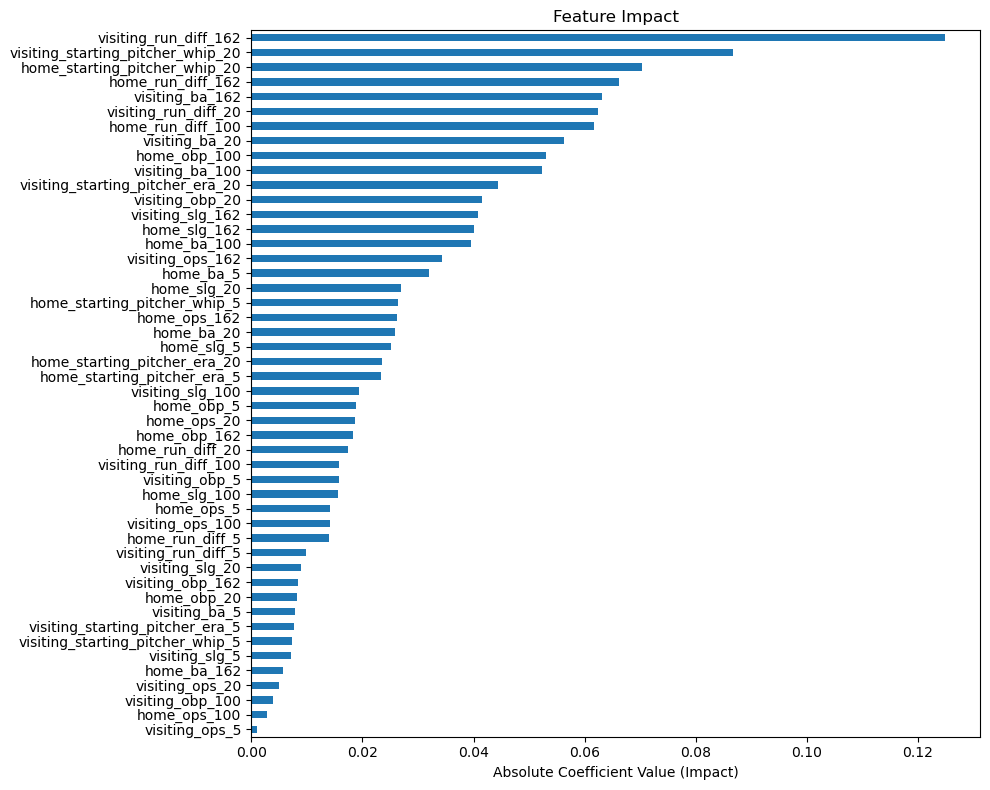

In [45]:
coefficients = pd.Series(LOGMODEL.coef_[0], index=x_train.columns)
coefficients.abs().sort_values(ascending=False).plot(kind='barh', figsize=(10, 8), title='Feature Impact')
plt.xlabel("Absolute Coefficient Value (Impact)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### How the Features Correlated to a Win or Loss

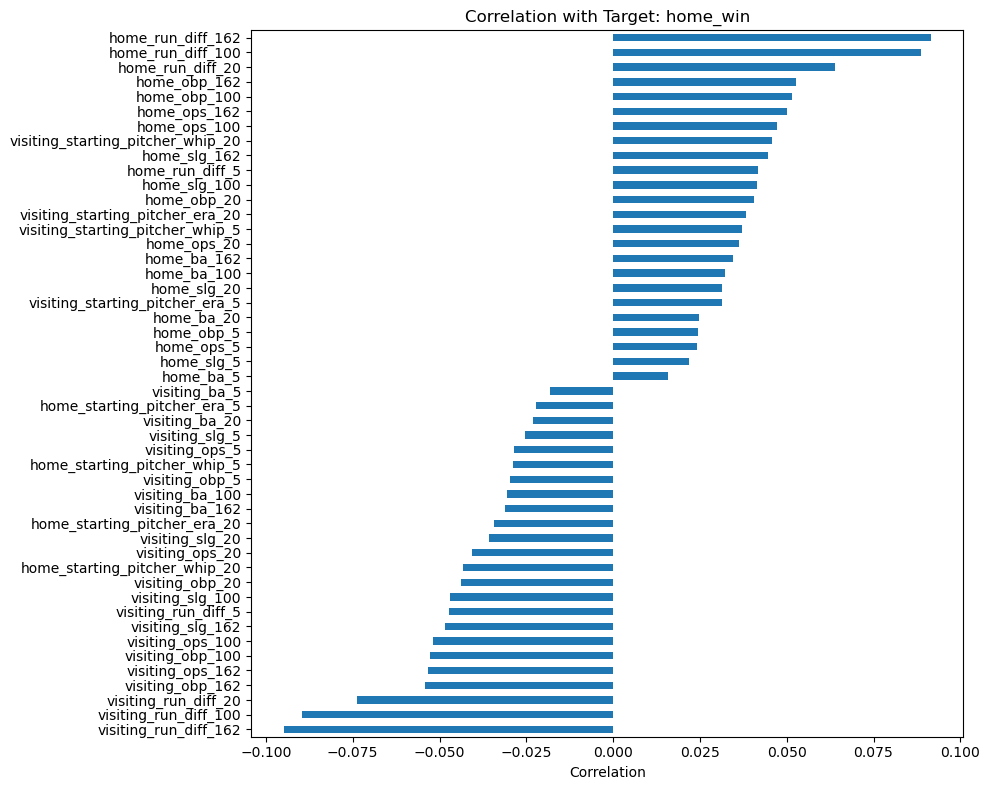

In [46]:
correlations = TRAINER_DF[TRAINING_FIELDS].corr()

# Drop the target row (self-correlation), then sort by correlation with the target
target = 'home_win'
correlations_target = correlations[target].drop(target).sort_values()

# Plot
correlations_target.plot(kind='barh', figsize=(10, 8), title='Correlation with Target: home_win')
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

#### Correlation Heatmap

<Axes: >

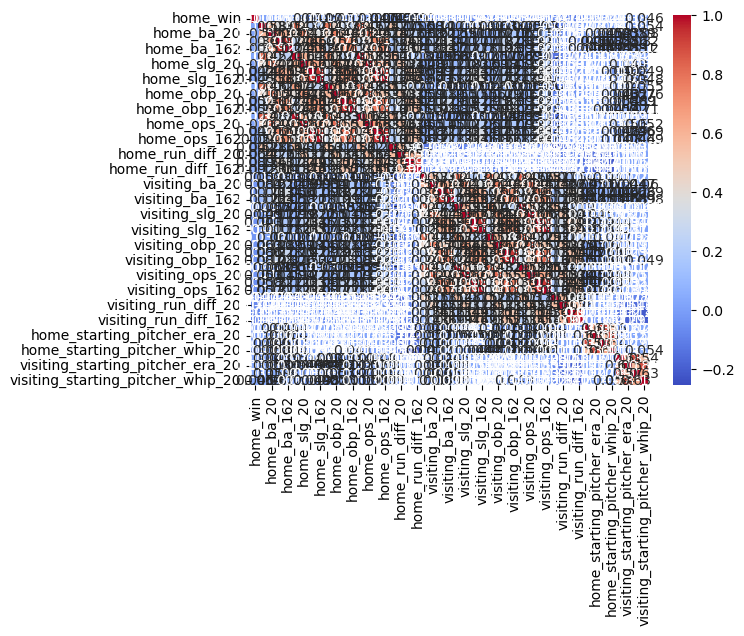

In [47]:
sns.heatmap(TRAINER_DF.corr(), cmap='coolwarm', annot=True)

#### How Often a Win or Loss is Predicted

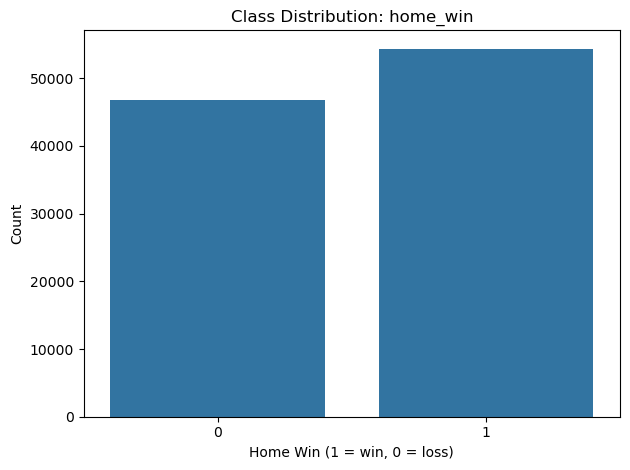

In [48]:
sns.countplot(x='home_win', data=_training_df)
plt.title('Class Distribution: home_win')
plt.xlabel('Home Win (1 = win, 0 = loss)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Predictions

Interactive elements that utilize the model to make predictions

### Get the player bio data

In [49]:
_players = pd.read_csv(f"{RETROSHEET_DIR}/reference/biofile.csv.zip")
_players.set_index('PLAYERID', inplace=True)

#### Only get the pitchers that pitched last season

Also define a method to get a list of pitchers for a team

In [50]:
last_season_pitching_data = PITCHING_DF[
    (PITCHING_DF['season'] == 2024)
].copy()

## Get the pitchers that have thrown more than 10 innings
def get_pitchers(pitcher_data, players_df, team_code):
    pitchers = pitcher_data[
        pitcher_data['team.key'] == team_code
        ][['person.key', 'P_IP']].groupby('person.key').sum().query('P_IP > 10')

    return players_df[players_df.index.isin(pitchers.index)]

#### Generate a list of teams and their pitchers for use in the interactive forms

In [51]:
team_data = {}

for _team in TEAMS.index:
    p = get_pitchers(last_season_pitching_data, _players, _team).copy()
    team_data[_team] = list(p.sort_values(by='LAST').apply(lambda r: (r.name, f"{r['NICKNAME']} {r['LAST']}"), axis=1))

teams = list(team_data.keys())

In [52]:
def get_last_team_stats(team_id):
    return TEAM_DATA[team_id].iloc[-1]

In [53]:
def get_last_pitching_stats(pitcher_id):
    return last_season_pitching_data[last_season_pitching_data['person.key'] \
                                     == pitcher_id].groupby('person.key').last().iloc[-1]

#### Create a Single Game Series

Given the team and the pitcher, create a Series with the batting and pitching statistics that we can use to generate predictions

In [54]:
def create_game_series(home_team_stats, home_pitcher_stats, away_team_stats, away_pitcher_stats):
    ## Batting
    batting_fields = [f"team_{s}_{batting_period}" for s in BATTING_STATS for batting_period in BATTING_PERIODS]

    home_batting = home_team_stats[batting_fields].rename(
        lambda f: f.replace('team_', 'home_') if f.startswith('team_') else f)
    away_batting = away_team_stats[batting_fields].rename(
        lambda f: f.replace('team_', 'visiting_') if f.startswith('team_') else f)

    batting = pd.concat([home_batting, away_batting], axis=0)

    ## Pitching
    home_pitching = home_pitcher_stats[PITCHING_STAT_MAPPER.keys()].rename(lambda z: f"home_{PITCHING_STAT_MAPPER[z]}")
    away_pitching = away_pitcher_stats[PITCHING_STAT_MAPPER.keys()].rename(lambda z: f"visiting_{PITCHING_STAT_MAPPER[z]}")

    pitching = pd.concat([home_pitching, away_pitching], axis=0)

    return pd.concat([batting, pitching])

#### Generate a Game Prediction

Given 2 teams and their starting pitchers, generate a prediction for a win or loss

In [55]:
def predict_game(model, home_team, home_pitcher_id, visiting_team, visiting_pitcher_id):
    home_team_stats = get_last_team_stats(home_team)
    home_pitcher_stats = get_last_pitching_stats(home_pitcher_id)

    away_team_stats = get_last_team_stats(visiting_team)
    away_pitcher_stats = get_last_pitching_stats(visiting_pitcher_id)

    game = create_game_series(home_team_stats, home_pitcher_stats, away_team_stats, away_pitcher_stats)

    game_df = pd.DataFrame([game])
    probs = model.predict_proba(game_df)

    return probs[0][1], probs[0][0]

### Create an Interactive Form to Predict a Game

In [56]:
layout_width = '400px'
label_width = '100px'

# Create dropdowns
home_team_dropdown = widgets.Dropdown(
    options=teams,
    description='Team:',
    layout=widgets.Layout(width=layout_width),
    style={'description_width': label_width}
)

home_player_dropdown = widgets.Dropdown(
    options=[],
    description='Starting Pitcher:',
    layout=widgets.Layout(width=layout_width),
    style={'description_width': label_width}
)

away_team_dropdown = widgets.Dropdown(
    options=teams,
    description='Team:',
    layout=widgets.Layout(width=layout_width),
    style={'description_width': label_width}
)

away_player_dropdown = widgets.Dropdown(
    options=[],
    description='Starting Pitcher:',
    layout=widgets.Layout(width=layout_width),
    style={'description_width': label_width}
)

win_loss_output = widgets.Output()


# Helper to format player dropdown
def format_players(player_list):
    return [(name, player_id) for player_id, name in player_list]


# Update player dropdowns
def update_home_players(change):
    home_players = format_players(team_data.get(change['new'], []))
    home_player_dropdown.options = home_players
    if change['new'] == away_team_dropdown.value:
        away_team_dropdown.value = next(home_team for home_team in teams if home_team != change['new'])


def update_away_players(change):
    away_players = format_players(team_data.get(change['new'], []))
    away_player_dropdown.options = away_players
    if change['new'] == home_team_dropdown.value:
        home_team_dropdown.value = next(away_team for away_team in teams if away_team != change['new'])


# Initial setup
update_home_players({'new': home_team_dropdown.value})
update_away_players({'new': away_team_dropdown.value})

# Set observers
home_team_dropdown.observe(update_home_players, names='value')
away_team_dropdown.observe(update_away_players, names='value')

# Submit button
submit_button = widgets.Button(description="Submit", button_style='primary')


def on_submit_clicked(b):
    with win_loss_output:
        clear_output()

        home_team_name = get_team_name(home_team_dropdown.value)
        away_team_name = get_team_name(away_team_dropdown.value)

        home_team_win, away_team_win = predict_game(
            PIPELINE,
            home_team_dropdown.value,
            home_player_dropdown.value,
            away_team_dropdown.value,
            away_player_dropdown.value
        )

        ## Graph        
        figure, ax = plt.subplots(figsize=(8, 1.5))

        # Draw the horizontal bar (just a thick line)
        ax.hlines(y=0, xmin=0, xmax=100, color='lightgray', linewidth=10)

        # Draw the marker at the predicted probability
        ax.plot(home_team_win * 100, 0, 'ro', markersize=12, label=f"{home_team_name} {home_team_win * 100:.2f}%")
        ax.plot(away_team_win * 100, 0, 'bo', markersize=12, label=f"{away_team_name} {away_team_win * 100:.2f}%")

        # Remove y-axis
        ax.get_yaxis().set_visible(False)

        # Add labels and grid
        ax.set_xlim(0, 100)
        ax.set_xlabel('Prediction Confidence (%)')
        ax.set_xticks(range(0, 101, 10))
        ax.set_title('Win Probability')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.tight_layout()
        plt.show()


submit_button.on_click(on_submit_clicked)

# Display UI
home_box = widgets.VBox([widgets.HTML(value="<h2>Home</h2>"), home_team_dropdown, home_player_dropdown])
away_box = widgets.VBox([widgets.HTML(value="<h2>Away</h2>"), away_team_dropdown, away_player_dropdown])
display(widgets.HBox([home_box, away_box]), submit_button, win_loss_output)

Button(button_style='primary', description='Submit', style=ButtonStyle())

Output()

### Given 2 Teams, how to all the pitching matchups affect the predictions of a game

In [57]:
def create_pitching_prediction_dataframe(home_team, away_team, player_data):
    # Extract pitcher ID -> last name mapping
    id_to_last_name = {
        pitcher_id: name.split()[-1]
        for current_team in [home_team, away_team]
        for pitcher_id, name in player_data.get(current_team, [])
    }

    # Get pitcher ID lists
    home_pitchers_list = [pitcher_id for pitcher_id, _ in player_data[home_team]]
    away_pitchers_list = [pitcher_id for pitcher_id, _ in player_data[away_team]]

    # Run predictions and store results
    results = []

    for h_pitcher in home_pitchers_list:
        row = {}
        for a_pitcher in away_pitchers_list:
            home_prob, away_prob = predict_game(PIPELINE, home_team, h_pitcher, away_team, a_pitcher)
            row[id_to_last_name[a_pitcher]] = home_prob * 100
            print(".", end="")
        results.append(pd.Series(row, name=id_to_last_name[h_pitcher]))

    pitching_prediction_dataframe = pd.DataFrame(results)
    pitching_prediction_dataframe.index.name = 'Home Pitcher'
    pitching_prediction_dataframe.columns.name = 'Away Pitcher'

    return pitching_prediction_dataframe

In [58]:
def create_prediction_heatmap(home_team, away_team, data):

    df = create_pitching_prediction_dataframe(home_team, away_team, data)

    # Plotly
    df_reset = df.reset_index().melt(id_vars='Home Pitcher', var_name='Away Pitcher', value_name='Win %')

    figure = px.density_heatmap(
        df_reset,
        x='Away Pitcher',
        y='Home Pitcher',
        z='Win %',
        color_continuous_scale='RdBu_r',
        range_color=[0, 100],
        text_auto='.1f'
    )

    figure.update_layout(
        title=f"{home_team} Win Probability vs {away_team} Pitchers",
        xaxis_title=away_team,
        yaxis_title=home_team,
        coloraxis_colorbar=dict(title="Win %"),
        yaxis=dict(autorange='reversed'),
        height=800
    )

    figure.show()

In [59]:
# Example list of teams (replace with your actual keys)
team_keys = sorted(team_data.keys())  # data is your dictionary of team -> pitchers

# Dropdown widgets
home_team_pitching_matchup_dropdown = widgets.Dropdown(
    options=team_keys,
    description='Home Team:',
    value='CHN',
    style={'description_width': 'initial'}
)

away_team_pitching_matchup_dropdown = widgets.Dropdown(
    options=team_keys,
    description='Away Team:',
    value='LAN',
    style={'description_width': 'initial'}
)

# Button to trigger the heatmap
run_button = widgets.Button(description='Generate Heatmap')

# Output area for the plot
pitching_output = widgets.Output()

# Function to run when button is clicked
def on_run_button_clicked(b):
    with pitching_output:
        clear_output(wait=True)
        home = home_team_pitching_matchup_dropdown.value
        away = away_team_pitching_matchup_dropdown.value
        create_prediction_heatmap(home, away, team_data)

# Link the function to the button
run_button.on_click(on_run_button_clicked)

# Display the widgets
form = widgets.VBox([home_team_pitching_matchup_dropdown, away_team_pitching_matchup_dropdown, run_button, pitching_output])
display(form)